In [1]:
# Running for the first time? Install Keras:
#!pip install keras
#!pip install tensorflow-gpu --yes
#!pip install opencv-python

In [2]:
import sklearn
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.inception_v3 import InceptionV3
# MobileNet?
import cv2
from PIL import Image
import pandas as pd
from os import listdir
from os.path import isfile, join

In [3]:
## Find name of 
import requests
def return_name(wnid):
    name = 'http://www.image-net.org/api/text/wordnet.synset.getwords?wnid='+wnid
    eng_name = requests.get(name).content.decode("utf-8").strip('\n')
    return eng_name

In [4]:
def read_process_image(path, transformation):
    """
    Reads an image and performs the desired transformation
    """
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    
    if img is None:
        return None, None
    rows,cols, channels = img.shape

    if transformation == 'translate':
        x_translate = 1
        y_translate = 1
        M = np.float32([[1,0,x_translate],[0,1,y_translate]]) # translation
        res = cv2.warpAffine(img,M,(cols,rows))
        
    if transformation == 'scale':
        scale_x = 1 # Reduce x by 1 pixel
        scale_y = 1
        res = cv2.resize(img,(cols - scale_x, rows - scale_y), interpolation = cv2.INTER_LINEAR)
        
    if transformation == 'rotate_180': # Rotates 180 deg
        res = cv2.rotate(img, cv2.ROTATE_180)
        
    if transformation == 'rotate_90': # Rotates 90 deg
        res = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
    if transformation == 'horizontal_flip':
        res = cv2.flip(img, 1)


    res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)
    res = Image.fromarray(res)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    return img, res

In [5]:
def preds_comparison(pred1, pred2):
    """
    Calculates metrics based on two sets of predictions.
    """
    k = len(pred1)
    if k < 1:
        return
    if pred1[0][0] == pred2[0][0]:
        top1_changed = 0
    else:
        top1_changed = 1
        
    top1_delta = abs(pred1[0][2] - pred2[0][2])
    
    avg_delta = abs(sum([abs(pred1[i][2] - pred2[i][2]) for i in range(k)]) / k)
    return top1_changed, top1_delta, avg_delta

In [6]:
def predict(model, img, img_transformed):
    """
    Given a model, an image and a transformed image, generate the predictions
    """
    k = 3
    # Original
    x = np.expand_dims(img, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    #print('Original:', decode_predictions(preds, top=3)[0])
    pred_orig = decode_predictions(preds, top=k)[0]
    top1_class_orig_pred = pred_orig[0][1]
    
    # Transformed 
    x = np.expand_dims(img_transformed, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    #print('Transformed:', decode_predictions(preds, top=k)[0])
    pred_trans = decode_predictions(preds, top=k)[0]
    top1_class_trans_pred = pred_trans[0][1]
    
    top1_changed, top1_delta, avg_delta = preds_comparison(pred_orig, pred_trans)
    return top1_changed, top1_delta, avg_delta, top1_class_orig_pred, top1_class_trans_pred

In [7]:
def run_model(model, wnid, transformation='translate'):
    output_df = pd.DataFrame([],
                       columns=['Class Name', 'Orig Pred Class Name', 'Trans Pred Class Name',
                                'Top 1 Changed', 'Top 1 Delta', 'Avg Delta', 'Path'])

    folder_path = 'images/{}/'.format(wnid)
    class_nm = return_name(wnid)
    image_paths = [folder_path + f for f in listdir(folder_path) if isfile(join(folder_path, f))]
    for image_path in image_paths:
        img, res = read_process_image(image_path, transformation)
        if img is None:
            continue
        top1_changed, top1_delta, avg_delta, top1_class_orig_pred, top1_class_trans_pred = predict(model, img, res)
        row_append = np.array([class_nm, top1_class_orig_pred, top1_class_trans_pred, top1_changed, top1_delta, avg_delta, image_path])
        output_df = output_df.append(dict(zip(output_df.columns, row_append)), ignore_index=True)

    output_df = output_df.astype(dtype= {"Top 1 Changed":"int64",
            "Top 1 Delta":"float64","Avg Delta":"float64"})
    return output_df

In [9]:
#output_df.loc[lambda f: f['Top 1 Changed'] == 1] # All results that changed
#output_df # All results

## Run for multiple transformations, save output

In [10]:
# Run for all transformations, same wnid, add a column to the output df that captures the transformation
wnid ='n03107488'
model = ResNet50(weights='imagenet')
translations=['translate','scale','rotate_180', 'rotate_90','horizontal_flip']
output_df = pd.DataFrame([],
                       columns=['Class Name', 'Orig Pred Class Name', 'Trans Pred Class Name',
                                'Top 1 Changed', 'Top 1 Delta', 'Avg Delta', 'Path','Transformation'])

for t in translations:
    temp = run_model(model,wnid,t)
    temp['Transformation'] = t
    output_df = output_df.append(temp)
    print('Finished ' + t)

output_name = wnid+'_all_transforms.csv'
output_df.to_csv(output_name)

Finished translate
Finished scale
Finished rotate_180
Finished rotate_90
Finished horizontal_flip


In [11]:
# Output the summary 
output_summary = output_df[['Class Name', 'Transformation', 'Top 1 Changed']].groupby(['Class Name', \
                'Transformation']).agg({'Top 1 Changed': ['sum', 'count']})
output_summary['pct_change'] = output_summary[('Top 1 Changed',   'sum')]\
                            /output_summary[('Top 1 Changed',   'count')]

output_summary

Top 1 Changed       pct_change
                                           sum count           
Class Name       Transformation                                
cords\ncorduroys horizontal_flip            44   195   0.225641
                 rotate_180                119   195   0.610256
                 rotate_90                 152   195   0.779487
                 scale                      38   195   0.194872
                 translate                  37   195   0.189744

## Visualizations

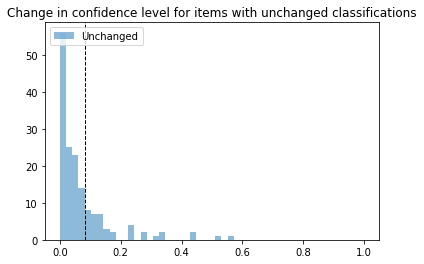

In [21]:
import matplotlib.pyplot as plt
bins = np.linspace(-0, 1, 50)
top_change = output_df[(output_df['Top 1 Changed'] == 0) & (output_df['Transformation'] == 'translate')]\
         ['Top 1 Delta'].quantile(0.75)

plt.hist(output_df[(output_df['Top 1 Changed'] == 0) & (output_df['Transformation'] == 'translate')]\
         ['Top 1 Delta'], bins, alpha = 0.5, label='Unchanged')
plt.legend(loc='upper left')
plt.title('Change in confidence level for items with unchanged classifications')
plt.axvline(top_change, color='k', linestyle='dashed', linewidth=1)

plt.show()

In [20]:
print(mean_change)

0.08168770175


In [13]:
output_df[(output_df['Top 1 Changed'] == 1) & (output_df['Transformation'] == 'translate')]

,Class Name,Orig Pred Class Name,Trans Pred Class Name,Top 1 Changed,Top 1 Delta,Avg Delta,Path,Transformation
0,cords\ncorduroys,sleeping_bag,cloak,1,0.013223,0.011507,images/n03107488/63.jpg,translate
2,cords\ncorduroys,jean,horizontal_bar,1,0.371102,0.181613,images/n03107488/162.jpg,translate
9,cords\ncorduroys,jean,velvet,1,0.028141,0.015433,images/n03107488/177.jpg,translate
11,cords\ncorduroys,parallel_bars,horizontal_bar,1,0.440897,0.212655,images/n03107488/76.jpg,translate
14,cords\ncorduroys,ski_mask,radiator,1,0.023071,0.038088,images/n03107488/149.jpg,translate
15,cords\ncorduroys,velvet,miniskirt,1,0.037408,0.044288,images/n03107488/175.jpg,translate
24,cords\ncorduroys,ski_mask,radiator,1,0.023071,0.038088,images/n03107488/59.jpg,translate
25,cords\ncorduroys,jean,horizontal_bar,1,0.371102,0.181613,images/n03107488/65.jpg,translate
36,cords\ncorduroys,jean,bow_tie,1,0.000257,0.001432,images/n03107488/99.jpg,translate
37,cords\ncorduroys,jean,barbershop,1,0.010969,0.006615,images/n03107488/211.jpg,translate
